# Espectro de un conjunto de transmons con PBC
Hacemos una cadena de transmons cada uno acoplado capacitivamente a sus primeros vecinos y conectamos el último con el primero de tal forma que:
$$
\hat H = \sum_j \hat H_j - \sum_j \hbar \tilde{g}_{j, j+1} (\hat b_j ^\dag - \hat b_j) (\hat b_{j+1}^\dag - \hat b_{j+1})
$$
Siendo $\hat H_j$ el hamiltoniano del transmon en la posición $j$ y 
$$
\hbar \tilde{g}_{j, j+1} = \frac{\left(E_J^j E_J^{j+1} (E_c^j E_c^{j+1})^3\right)^{1/4}}{\sqrt{2} E_c^{j, j+1}}
$$
con $E_c^{j, j+1} = \frac{e^2}{C_{j \rightarrow j+1}}$ la energía de carga asociada al capacitor de acople entre ambos sitios. Para simplificar las cuentas, primero consideraremos que todos los transmons tienen las mismas energías de Josephson y de carga, además que los capacitores de acople son todos iguales. Para simular correctamente el transporte de partículas debemos tener en cuenta las relaciones entre las energías asociadas a los orbitales, las interacciones y el acoplamiento (hopping). En nuestro caso, esto corresponde a fijarnos en las siguientes razones:
$$
\frac{\lambda}{\omega} = \frac{1}{24}\sqrt{\frac{E_c}{2E_J}} \sim 0.04,\quad  \text{para}\,\, E_J / E_c = 50.0
$$
$$
\frac{g_c}{\omega} = \frac{E_c}{4E_g}
$$
$$
\frac{\lambda}{g_c} = \frac{E_g}{6\sqrt{2E_cE_J}} = \frac{E_g}{60E_c},\quad \text{para}\,\, E_J / E_c = 50.0
$$
Si hacemos $E_g\sim 2E_c$, tenemos un régimen en el cual las interacciones son mucho menores al hopping ($\lambda / g_c \sim 0.03$) y el hopping a su vez es un poco menor a la separación típica de niveles ($g_c / \omega \sim 0.12$). En adelante usaremos como referencia $\frac{E_J}{E_c} = 50$ y $E_g \sim 2E_c$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.special import genlaguerre, gammaln
import itertools
import scienceplots
plt.style.use(['science', 'notebook'])

In [ ]:
# def compute_position_exponential(N, u): 
#   matrix = np.zeros(shape= (N, N), dtype = complex)
#   for m in range(N):
#     for n in range(N):
#       if m >= n:
#         matrix[m][n] = np.exp(-u**2/2) * np.sqrt(factorial(n)/factorial(m)) * (1.0j*u)**(m-n)*genlaguerre(n, m-n)(u**2)
#       else:
#         matrix[m][n] = np.exp(-u**2/2) * np.sqrt(factorial(m)/factorial(n)) * (1.0j*u)**(n-m)*genlaguerre(m, n-m)(u**2)

#   return qt.Qobj(matrix)


In [ ]:
# expresion analitica para la matriz (en base de fock) del operador e^{i u (\hat a + \hat a^\dag)}
def compute_position_exponential(N, u): 
  matrix = np.zeros(shape=(N, N), dtype=complex)
  for m in range(N):
    for n in range(N):
      if m >= n:
        matrix[m][n] = (
          np.exp(-u**2/2)
          * np.exp(0.5 * (gammaln(n+1) - gammaln(m+1)))
          * (1.0j*u)**(m-n)
          * genlaguerre(n, m-n)(u**2)
        )
      else:
        matrix[m][n] = (
          np.exp(-u**2/2)
          * np.exp(0.5 * (gammaln(m+1) - gammaln(n+1)))
          * (1.0j*u)**(n-m)
          * genlaguerre(m, n-m)(u**2)
        )

  return qt.Qobj(matrix)

# hamiltoniano exacto con dimensión truncada en N estados de Fock
def exact_transmon_hamiltonian(N, E_c, E_j):
    charge_number = 0.5j * (E_j/(2*E_c))**0.25 * (qt.destroy(N).dag() - qt.destroy(N))
    phase_prefactor = (2 * E_c / E_j)**0.25
    cos_delta = 0.5 * (compute_position_exponential(N, phase_prefactor) + compute_position_exponential(N, -phase_prefactor))
    return 4 * E_c * charge_number**2 - E_j * cos_delta

# términos para el término de orden 4
def O_0(N):
  return 6 * qt.destroy(N).dag()**2 * qt.destroy(N)**2 + 12 * qt.num(N)

def O_2(N):
  return 4 * (qt.destroy(N).dag()**3 * qt.destroy(N) + qt.destroy(N).dag() * qt.destroy(N)**3) + 6 * (qt.destroy(N)**2 + qt.destroy(N).dag()**2)

def O_4(N):
  return qt.destroy(N)**4 + qt.destroy(N).dag()**4

In [ ]:
# hamiltoniano de una cadena de transmons con PBC, N = dimension del espacio de Fock de cada transmon, 
# n = numero de transmons, E_g = energia de carga del coupler

def exact_transmon_chain(N, n, E_c, E_J, E_g):
    op_list = [qt.qeye(N) for _ in range(n)]
    full_hamiltonian = qt.qzero_like(qt.tensor(op_list))
    H_j = exact_transmon_hamiltonian(N, E_c, E_J)
    # suma de hamiltonianos actuando sobre cada uno de los transmon por separado
    for j in range(n):
        op_list[j] = H_j
        full_hamiltonian += qt.tensor(op_list)
        op_list[j] = qt.qeye(N)
    hbar_g = (E_J * E_c**3)**0.5 / (np.sqrt(2) * E_g)
    # sumamos términos de acoplamiento
    a = qt.destroy(N)
    charge_op = (a.dag() - a)

    for j in range(n):
        op_list[j] = charge_op
        op_list[(j+1) % n] = charge_op

        full_hamiltonian -= hbar_g * qt.tensor(op_list)

        op_list[j] = qt.qeye(N)
        op_list[(j+1) % n] = qt.qeye(N)
    
    return full_hamiltonian

def approximate_transmon_chain_0(N, n, E_c, E_J, E_g):
    op_list = [qt.qeye(N) for _ in range(n)]
    full_hamiltonian = qt.qzero_like(qt.tensor(op_list))
    # suma de hamiltonianos actuando sobre cada uno de los transmon por separado
    H_j = np.sqrt(8 * E_c * E_J) * qt.num(N) - (E_c / 12.0) * (O_0(N)) 
    for j in range(n):
        op_list[j] = H_j
        full_hamiltonian += qt.tensor(op_list)
        op_list[j] = qt.qeye(N)
    hbar_g = (E_J * E_c**3)**0.5 / (np.sqrt(2) * E_g)
    # sumamos términos de acoplamiento
    a = qt.destroy(N)
    charge_op = (a.dag() - a)

    for j in range(n):
        op_list[j] = charge_op
        op_list[(j+1) % n] = charge_op

        full_hamiltonian -= hbar_g * qt.tensor(op_list)

        op_list[j] = qt.qeye(N)
        op_list[(j+1) % n] = qt.qeye(N)
    
    return full_hamiltonian

def approximate_transmon_chain_2(N, n, E_c, E_J, E_g):
    op_list = [qt.qeye(N) for _ in range(n)]
    full_hamiltonian = qt.qzero_like(qt.tensor(op_list))
    # suma de hamiltonianos actuando sobre cada uno de los transmon por separado
    H_j = np.sqrt(8 * E_c * E_J) * qt.num(N) - (E_c / 12.0) * (O_0(N) + O_2(N)) 
    for j in range(n):
        op_list[j] = H_j
        full_hamiltonian += qt.tensor(op_list)
        op_list[j] = qt.qeye(N)
    hbar_g = (E_J * E_c**3)**0.5 / (np.sqrt(2) * E_g)
    # sumamos términos de acoplamiento
    a = qt.destroy(N)
    charge_op = (a.dag() - a)

    for j in range(n):
        op_list[j] = charge_op
        op_list[(j+1) % n] = charge_op

        full_hamiltonian -= hbar_g * qt.tensor(op_list)

        op_list[j] = qt.qeye(N)
        op_list[(j+1) % n] = qt.qeye(N)
    
    return full_hamiltonian

In [ ]:

# # estado de fock compuesto dado un array con el número de excitaciones en cada sitio, si no se da el array se devuelve el vacuum state
# def composite_fock_state(N, n, state_id=None):
#     if state_id is None:
#         ket_list = [qt.basis(N, 0) for _ in range(n)]
#     else:
#         ket_list = [qt.basis(N, j) for j in state_id]
#     return qt.tensor(ket_list)

# # lista de estados en espacio k con l excitaciones y una base truncada hasta n estados de Fock
# def composite_k_state(N, n, state_id=None):
#     k_values = np.linspace(-np.pi, np.pi, n, endpoint=False)
#     vacuum = composite_fock_state(N, n)
    
#     if state_id is None or np.sum(state_id) == 0:
#         return vacuum
    
#     state = vacuum
#     creation_operator = qt.destroy(N).dag()
    
#     # para cada modo de momento k
#     for k, quanta in zip(k_values, state_id):
#         if quanta > 0:
#             # construir b_k^\dagger = (1/√n) Σ_j e^{ikj} b_j^\dagger
#             op_list = [qt.qeye(N) for _ in range(n)]
#             b_k_dag = None
            
#             for j in range(n):
#                 op_list[j] = creation_operator
#                 term = qt.tensor(op_list) * np.exp(1.0j * k * j) / np.sqrt(n)
                
#                 if b_k_dag is None:
#                     b_k_dag = term
#                 else:
#                     b_k_dag += term
                
#                 op_list[j] = qt.qeye(N)
            
#             # aplicar (b_k^\dagger)^quanta / sqrt(quanta!)
#             for _ in range(int(quanta)):
#                 state = b_k_dag * state
#             state = state / np.exp(0.5 * gammaln(quanta + 1))
    
#     # normalizar
#     norm = state.norm()
#     if norm > 1e-10:
#         state = state / norm
    
#     return state

# # matriz que transforma del espacio real al espacio de momentos
# def get_k_space_unitary(N, n):
#     # generamos todos los id posibles:
#     combinations = np.array([idx for idx in np.ndindex(*[N]*n)])
    
#     # inicializar matriz cero
#     dim = N**n
#     U_matrix = np.zeros((dim, dim), dtype=complex)
    
#     for combo in combinations:
#         k_state = composite_k_state(N, n, combo)
#         real_state = composite_fock_state(N, n, combo)
        
#         # agregar |k⟩⟨real|
#         U_matrix += np.outer(k_state.full().flatten(), 
#                             real_state.full().flatten().conj())
    
#     return qt.Qobj(U_matrix, dims=[[N]*n, [N]*n])

In [18]:
N = 8
n = 4
E_c = 1.0
E_j = 50.0
E_g_values = E_c * np.linspace(1.0, 3.0, 50)
energies = []
for E_g in E_g_values:
    hamilitonian = exact_transmon_chain(N, n, E_c, E_j, E_g)
    energies.append(np.array(hamilitonian.eigenenergies()))

energies = np.array(energies)

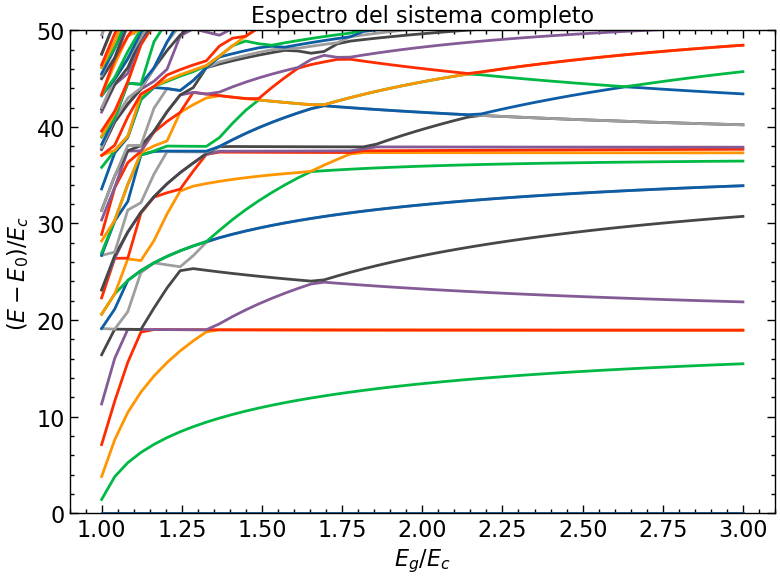

In [21]:
for bands in energies.T:
    plt.plot(E_g_values, bands-energies.T[0])

y_min = 0.0
y_max = 50.0
plt.ylim(y_min, y_max)
# x_min = 0.0
# x_max = 20.05
# plt.xlim(x_min, x_max)
plt.xlabel('$E_g/E_c$')
plt.ylabel('$(E - E_0) / E_c$ ')
plt.title('Espectro del sistema completo')
plt.tight_layout()

# Comparación en función del truncamiento

In [5]:
N_values = [5, 8, 9, 10]
n = 4
E_c = 1.0
E_j = 50.0
E_g_values = E_c * np.linspace(1.0, 3.0, 10)
energy_matrix = []
for N in N_values:
    energies = []
    for E_g in E_g_values:
        hamilitonian = exact_transmon_chain(N, n, E_c, E_j, E_g)
        energies.append(np.array(hamilitonian.eigenenergies()))

    energy_matrix.append(np.array(energies))
    
energy_matrix = np.array(energy_matrix)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (4, 10) + inhomogeneous part.

/tmp/ipykernel_49141/1213678650.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


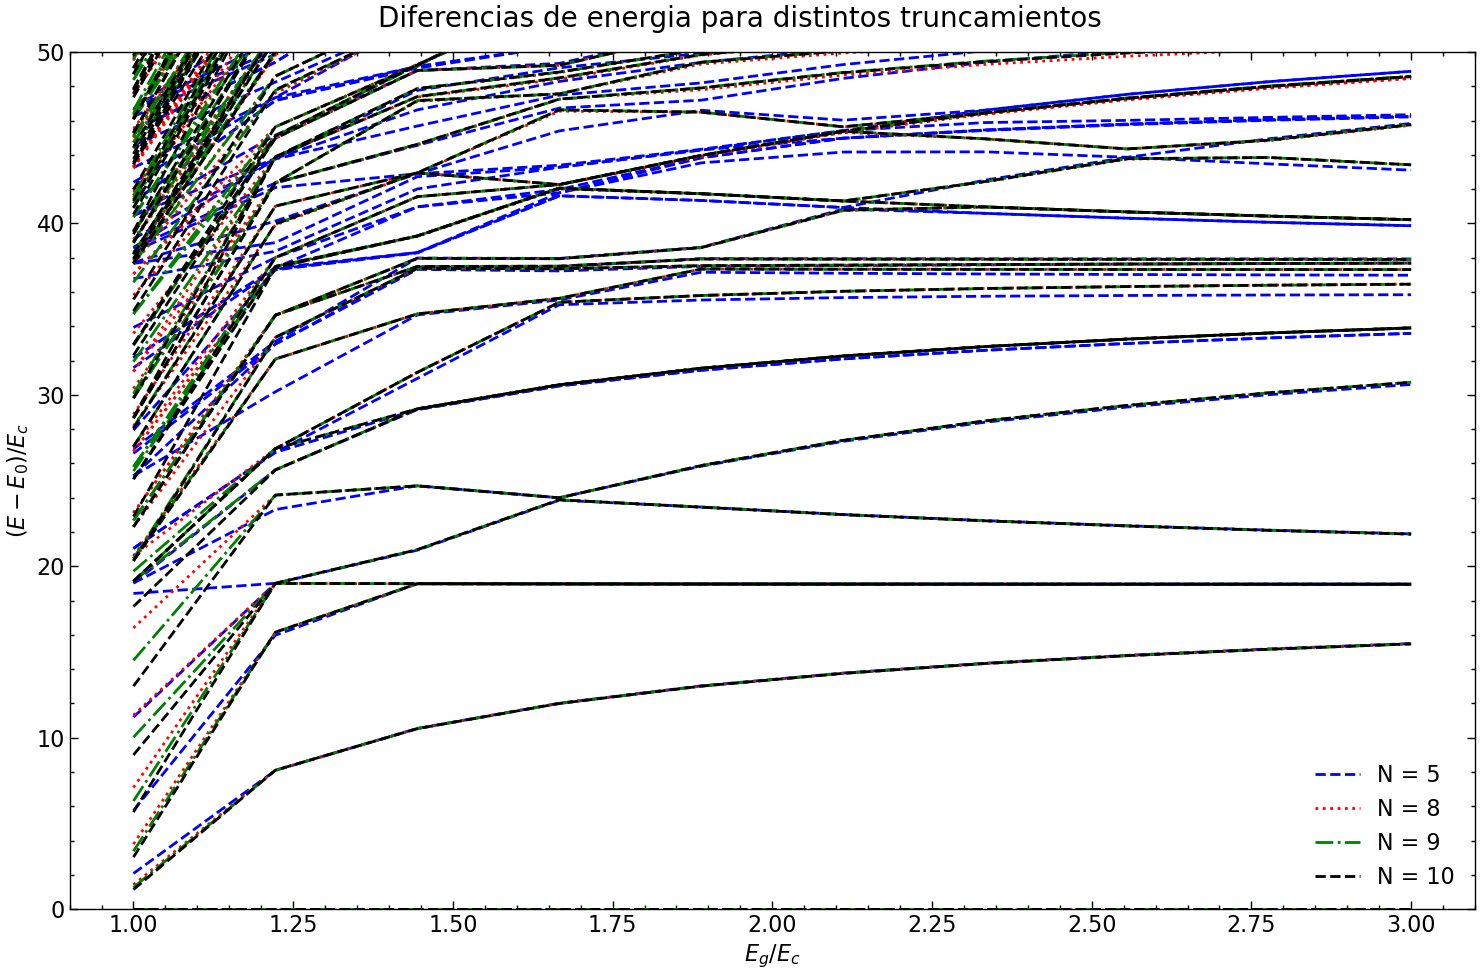

In [15]:
fig, ax = plt.subplots(figsize = (15, 10))
fig.suptitle('Diferencias de energia para distintos truncamientos', fontsize = 20)
styles = ['b--', 'r:', 'g-.', 'k--']
ax.set_xlabel('$E_g/E_c$')
ax.set_ylabel('$(E- E_0)/E_c$')
for energy_array, style, N in zip(energy_matrix, styles, N_values):
    ground = energy_array.T[0]
    for level_idx, level in enumerate(energy_array.T):
        if level_idx == 0:
            ax.plot(E_g_values, np.zeros_like(level), style, label = f"N = {N}")
        else:
            ax.plot(E_g_values, level-ground, style)

y_min = 0.0
y_max = 50.0
ax.set_ylim(y_min, y_max)
plt.legend()
fig.tight_layout()
plt.show()

Vemos que los primeros 8 niveles de energía (que corresponderían a las dos primeras bandas) tienen un gran error de truncamiento cuando $E_g/E_c \lesssim 1.5$, probablemente porque el término de interacción empieza a tener mayor peso sobre el espectro en ese rango y por tanto empieza a mezclar estados con mayor número de excitaciones. Por otra parte, vemos que las energías obtenidas para $N= 8,\,9,\,10$ son muy similares fuera de ese régimen por lo cual nos mantendremos en $N = 8$.

# Comparación en función de la aproximación utilizada

In [18]:
N = 8
n = 4
E_c = 1.0
E_j = 50.0
E_g_values = E_c * np.linspace(1.0, 3.0, 10)
hamiltonians = [exact_transmon_chain, approximate_transmon_chain_0, approximate_transmon_chain_2]
energy_matrix = []

for hamiltonian_function in hamiltonians:
    energies = []
    for E_g in E_g_values:
        hamilitonian = hamiltonian_function(N, n, E_c, E_j, E_g)
        energies.append(np.array(hamilitonian.eigenenergies()))

    energy_matrix.append(np.array(energies))
    
energy_matrix = np.array(energy_matrix)

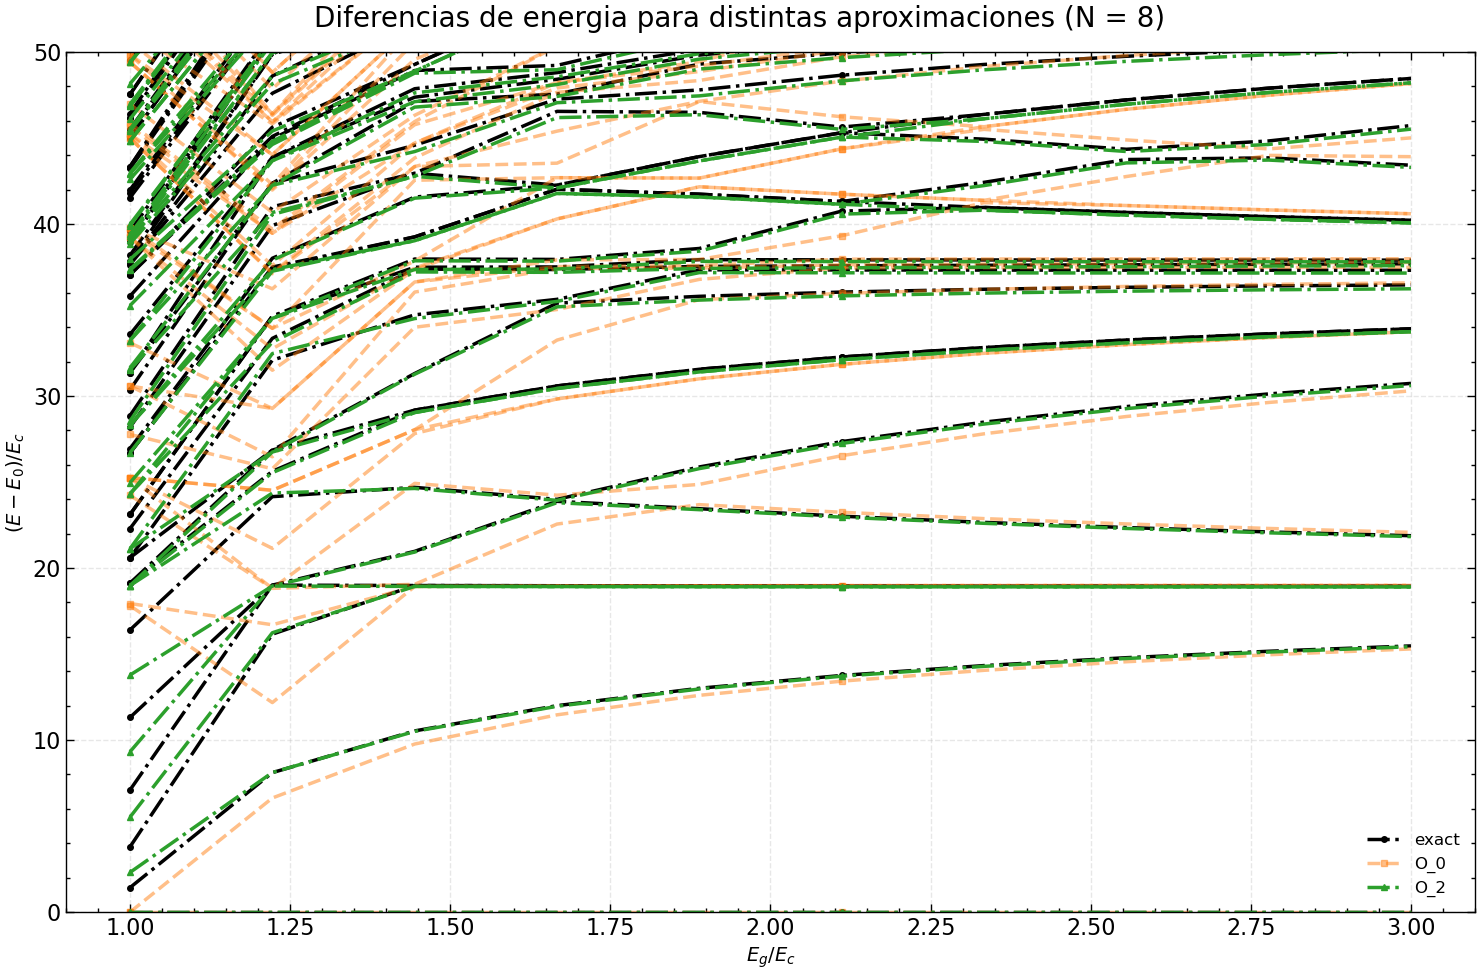

In [26]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle('Diferencias de energia para distintas aproximaciones (N = 8)', fontsize=20)

# More distinct styles with different colors, line styles, and markers
styles = [
    {'color': "#000000", 'linestyle': '-.', 'linewidth': 2.5, 'marker': 'o', 'markersize': 4, 'markevery': 5},
    {'color': "#ff7e0e7d", 'linestyle': '--', 'linewidth': 2.5, 'marker': 's', 'markersize': 4, 'markevery': 5},
    {'color': '#2ca02c', 'linestyle': '-.', 'linewidth': 2.5, 'marker': '^', 'markersize': 4, 'markevery': 5}
]
labels = ['exact', 'O_0', 'O_2']

ax.set_xlabel('$E_g/E_c$', fontsize=14)
ax.set_ylabel('$(E- E_0)/E_c$', fontsize=14)

for energy_array, style, labl in zip(energy_matrix, styles, labels):
    ground = energy_array.T[0]
    for level_idx, level in enumerate(energy_array.T):
        if level_idx == 0:
            ax.plot(E_g_values, np.zeros_like(level), 
                   label=labl, **style)
        else:
            ax.plot(E_g_values, level - ground, **style)

y_min = 0.0
y_max = 50.0
ax.set_ylim(y_min, y_max)
ax.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=12, framealpha=0.9)
fig.tight_layout()
plt.show()

Al igual que en el caso de un solo transmon, nos quedamos muy cortos con la primera aproximación y tenemos que incluir el término que genera transiciones de dos cuantos. En adelante solo consideraremos la aproximación hasta incluir el término $O_2$. Es de notar además que la aproximación funciona mejor conforme aumenta $E_g / E_c$. 

# Comparación a orden cuadrático
Resulta que el término $O_0$ tiene un término de orden cuatro y $O_2$ tiene una parte que es de orden 2 y otra de orden 4, consideremos la aproximación en el hamiltoniano que mantiene solamente términos de orden cuadrático:
$$
\hat H_j = \hbar \omega_q \hat b_j^\dag \hat b_j -\hbar \lambda\left(12 \hat b_j^\dag \hat b_j + 6 \left[(\hat b_j^\dag)^2 + (\hat b_j)^2\right]\right)
$$
Comparamos esta aproximación con la diagonalización exacta y con la inclusión del término de interacción.

In [33]:
def quadratic_transmon_chain(N, n, E_c, E_J, E_g):
    op_list = [qt.qeye(N) for _ in range(n)]
    full_hamiltonian = qt.qzero_like(qt.tensor(op_list))
    # suma de hamiltonianos actuando sobre cada uno de los transmon por separado
    H_j = np.sqrt(8 * E_c * E_J) * qt.num(N) - (E_c / 12.0) * (12 * qt.num(N) + 6 * (qt.destroy(N)**2 + qt.destroy(N).dag()**2)) 
    for j in range(n):
        op_list[j] = H_j
        full_hamiltonian += qt.tensor(op_list)
        op_list[j] = qt.qeye(N)
    hbar_g = (E_J * E_c**3)**0.5 / (np.sqrt(2) * E_g)
    # sumamos términos de acoplamiento
    a = qt.destroy(N)
    charge_op = (a.dag() - a)

    for j in range(n):
        op_list[j] = charge_op
        op_list[(j+1) % n] = charge_op

        full_hamiltonian -= hbar_g * qt.tensor(op_list)

        op_list[j] = qt.qeye(N)
        op_list[(j+1) % n] = qt.qeye(N)
    
    return full_hamiltonian

# hamiltoniano cuadrático con la no linealidad de Kerr
def interacting_quadratic_chain(N, n, E_c, E_J, E_g):
    op_list = [qt.qeye(N) for _ in range(n)]
    full_hamiltonian = qt.qzero_like(qt.tensor(op_list))
    # suma de hamiltonianos actuando sobre cada uno de los transmon por separado
    H_j = np.sqrt(8 * E_c * E_J) * qt.num(N) - (E_c / 12.0) * (12 * qt.num(N) + 6 * (qt.destroy(N)**2 + qt.destroy(N).dag()**2) + 6 * qt.destroy(N).dag()**2 * qt.destroy(N)**2) 
    for j in range(n):
        op_list[j] = H_j
        full_hamiltonian += qt.tensor(op_list)
        op_list[j] = qt.qeye(N)
    hbar_g = (E_J * E_c**3)**0.5 / (np.sqrt(2) * E_g)
    # sumamos términos de acoplamiento
    a = qt.destroy(N)
    charge_op = (a.dag() - a)

    for j in range(n):
        op_list[j] = charge_op
        op_list[(j+1) % n] = charge_op

        full_hamiltonian -= hbar_g * qt.tensor(op_list)

        op_list[j] = qt.qeye(N)
        op_list[(j+1) % n] = qt.qeye(N)
    
    return full_hamiltonian

In [34]:
N = 8
n = 4
E_c = 1.0
E_j = 50.0
E_g_values = E_c * np.linspace(1.0, 3.0, 10)
hamiltonians = [exact_transmon_chain, quadratic_transmon_chain, interacting_quadratic_chain]
energy_matrix = []

for hamiltonian_function in hamiltonians:
    energies = []
    for E_g in E_g_values:
        hamilitonian = hamiltonian_function(N, n, E_c, E_j, E_g)
        energies.append(np.array(hamilitonian.eigenenergies()))

    energy_matrix.append(np.array(energies))
    
energy_matrix = np.array(energy_matrix)

/home/ruiz/miniconda3/envs/quantum/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


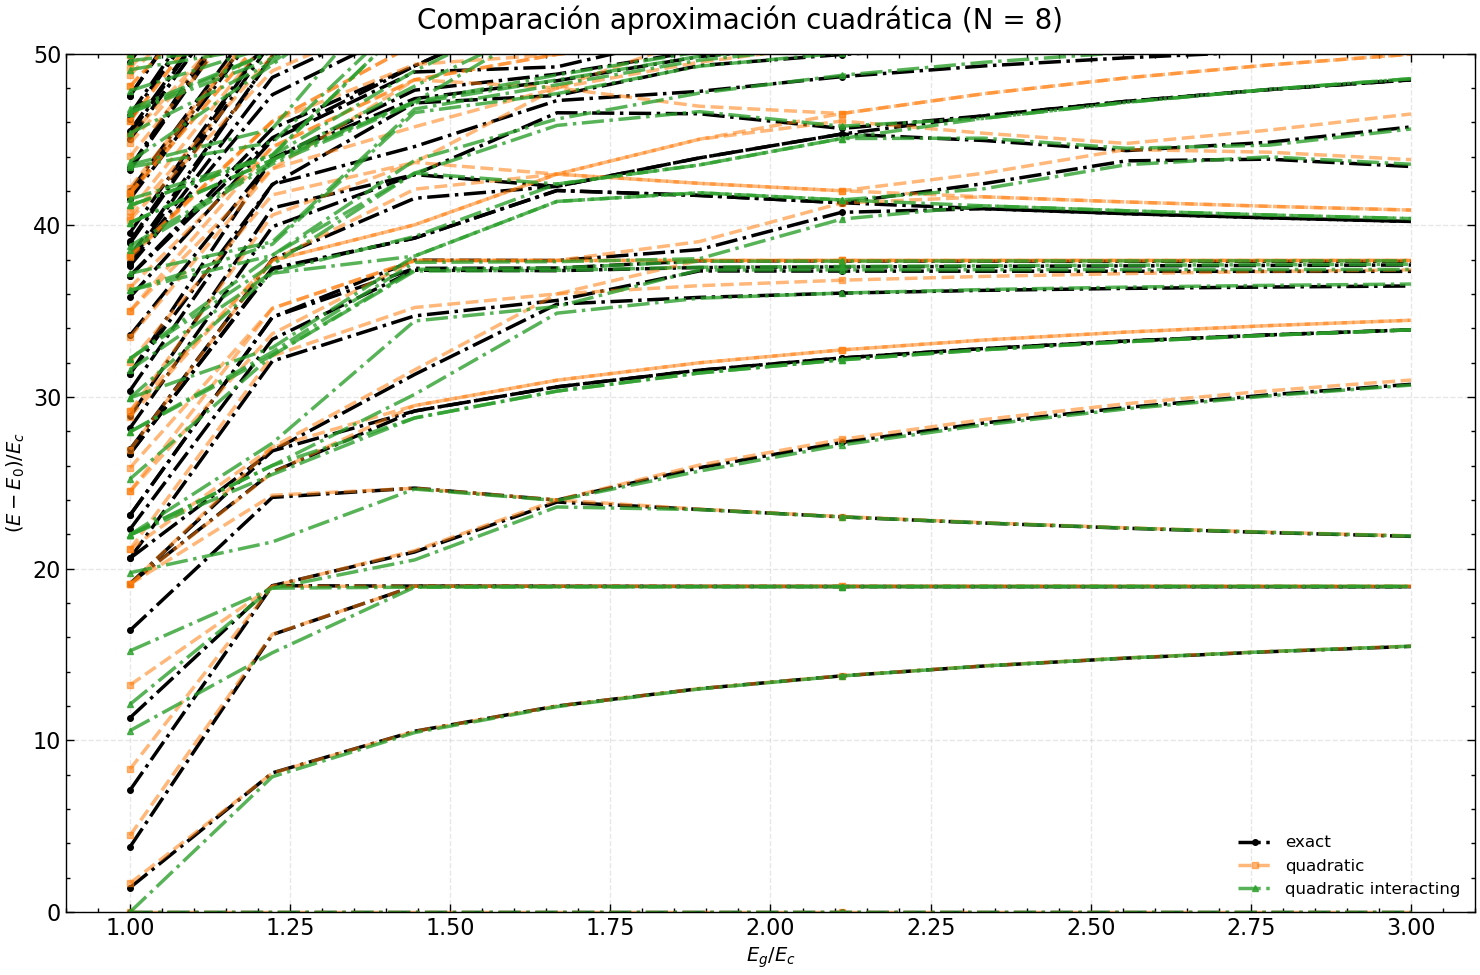

In [37]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle('Comparación aproximación cuadrática (N = 8)', fontsize=20)

# More distinct styles with different colors, line styles, and markers
styles = [
    {'color': "#000000", 'linestyle': '-.', 'linewidth': 2.5, 'marker': 'o', 'markersize': 4, 'markevery': 5},
    {'color': "#ff7e0e8d", 'linestyle': '--', 'linewidth': 2.5, 'marker': 's', 'markersize': 4, 'markevery': 5},
    {'color': "#2ca02cca", 'linestyle': '-.', 'linewidth': 2.5, 'marker': '^', 'markersize': 4, 'markevery': 5}
]
labels = ['exact', 'quadratic', 'quadratic interacting']

ax.set_xlabel('$E_g/E_c$', fontsize=14)
ax.set_ylabel('$(E- E_0)/E_c$', fontsize=14)

for energy_array, style, labl in zip(energy_matrix, styles, labels):
    ground = energy_array.T[0]
    for level_idx, level in enumerate(energy_array.T):
        if level_idx == 0:
            ax.plot(E_g_values, np.zeros_like(level), 
                   label=labl, **style)
        else:
            ax.plot(E_g_values, level - ground, **style)

y_min = 0.0
y_max = 50.0
ax.set_ylim(y_min, y_max)
ax.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=12, framealpha=0.9)
fig.tight_layout()
plt.show()

La aproximación cuadrática es mejor que la que incluye $O_0$ pero no tan buena como la que también incluye $O_2$. Un desempeño muy similar a esta última se logra incluyendo la interacción.